<div class="alert alert-block alert-info">
    <h2><center>Distracted Driver Detection Using CNN</center></h2>
    <center><p>Languaje used: Python</p>
        <p>Framework used: tf.keras</p>
    </center>
</div>

## Libraries

In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

## Preprocessing data

In [2]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

## Get Data

In [3]:
#Paths
pathTrain_Images = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


## Check data integrity

### Classes:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

17939
(128, 128, 3)


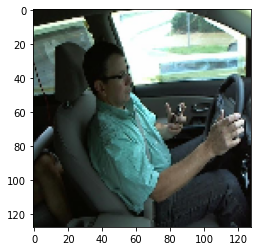

Class: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [4]:
print(len(X_Train))
print(X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

## Check data distribution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

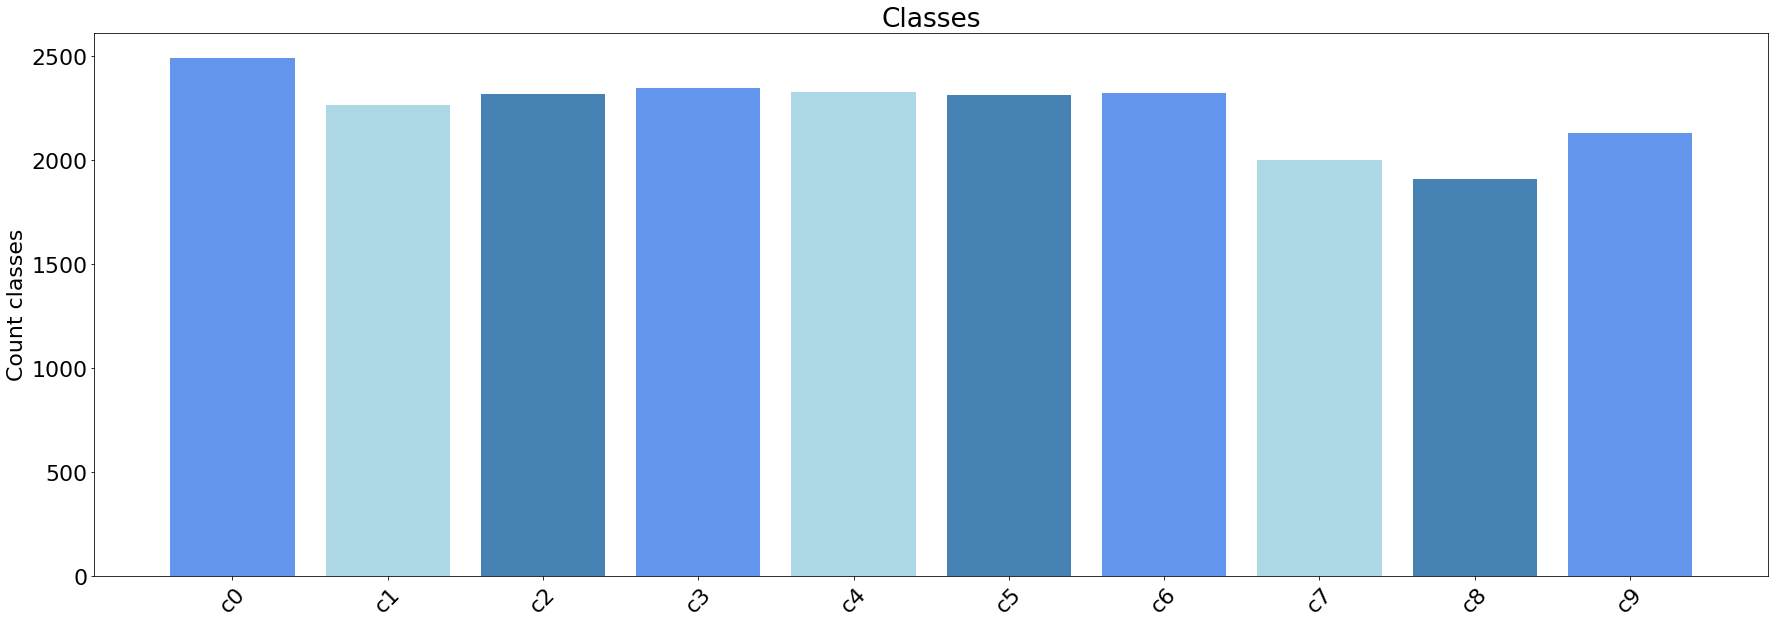

In [5]:
data_file = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

# Create architecture

In [6]:

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(
    input_shape=(128, 128, 3)
))

model.add(
    keras.layers.Conv2D(
        filters=32,
        kernel_size=(5,5),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_1'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_1'))#Image_size: 32*64*64(32 filters,image_size 64*64)

model.add(
    keras.layers.Conv2D(
        filters = 64,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_2'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_2'))#Image_size: 64*32*32(64 filters,image_size 32*32)

model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_3'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_3'))#Image_size: 128*16*16(128 filters,image_size 16*16)

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (5,5),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_4'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_4'))#Image_size: 256*8*8(256 filters,image_size 8*8)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu',name = 'fc_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation='softmax',name = 'fc_3'))
model.save('/tmp/model')
#model.compute_output_shape(input_shape=(256,8,8,1))

In [7]:
tf.random.set_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 64, 64, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        51264     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 128)       204928    
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 16, 16, 128)       0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 16, 16, 256)       8

## Train model

In [8]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 10, batch_size = 500, verbose = 1,validation_split=0.2)

Epoch 1/10
29/29 [==============================] - 8s 282ms/step - loss: 12.7305 - accuracy: 0.2145 - val_loss: 1.6393 - val_accuracy: 0.3963
Epoch 2/10
29/29 [==============================] - 7s 226ms/step - loss: 1.1814 - accuracy: 0.5776 - val_loss: 0.6417 - val_accuracy: 0.7965
Epoch 3/10
29/29 [==============================] - 7s 226ms/step - loss: 0.4642 - accuracy: 0.8535 - val_loss: 0.2603 - val_accuracy: 0.9284
Epoch 4/10
29/29 [==============================] - 7s 226ms/step - loss: 0.2023 - accuracy: 0.9404 - val_loss: 0.1485 - val_accuracy: 0.9660
Epoch 5/10
29/29 [==============================] - 7s 225ms/step - loss: 0.1148 - accuracy: 0.9661 - val_loss: 0.1096 - val_accuracy: 0.9677
Epoch 6/10
29/29 [==============================] - 7s 226ms/step - loss: 0.0779 - accuracy: 0.9782 - val_loss: 0.0906 - val_accuracy: 0.9766
Epoch 7/10
29/29 [==============================] - 7s 226ms/step - loss: 0.0582 - accuracy: 0.9830 - val_loss: 0.0834 - val_accuracy: 0.9799
Epoch

## Evaluate model with test data

In [9]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 1s 9ms/step - loss: 0.0737 - accuracy: 0.9833


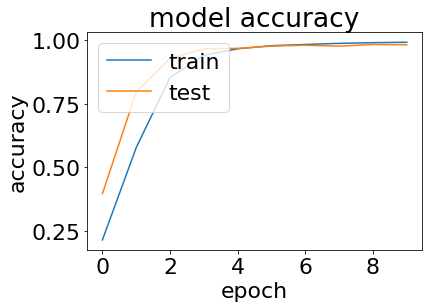

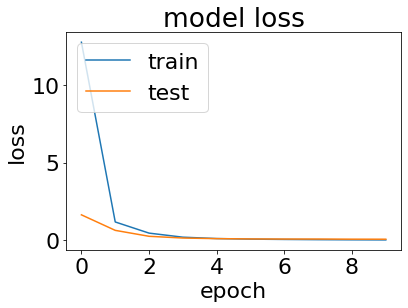

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

### Save weights

In [11]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [12]:
model.load_weights('Train_weights_1.h5')

## Show architecture distribution

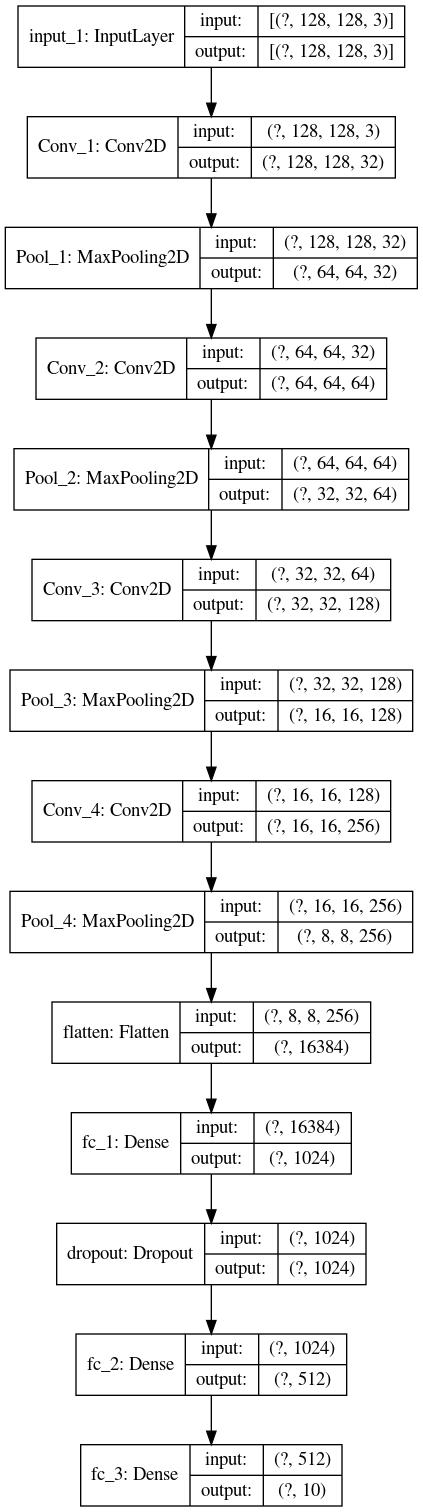

In [13]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

## Predict Test data and create a submission file

In [14]:
df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(pathPropagate_Images,df):
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        img_cv_r = cv2.resize(img_cv,(128,128))
        img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
        arr_predict = model.predict(img_cv_predict,batch_size = 1)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [15]:
img_cv = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_41.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))

[[9.5432204e-01 3.2908187e-07 1.6887544e-04 4.5685754e-03 8.0092689e-03
  7.1880454e-06 4.3900773e-06 5.5051351e-06 4.0801617e-05 3.2872964e-02]]
0.03


[[3.3705916e-08 3.6367106e-05 6.6275991e-02 2.5079910e-11 6.8508234e-07
  3.8331079e-12 9.3368679e-01 8.6850267e-12 1.1753755e-07 5.5050083e-12]]
0.0


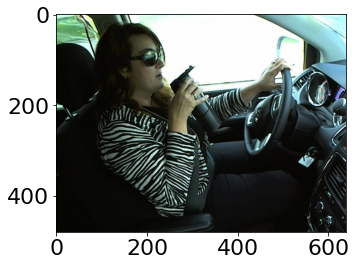

In [28]:
img_cv = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_4.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)
plt.imshow(cv2.cvtColor(img_cv , cv2.COLOR_BGR2RGB))

print(arr_predict)
print(round(arr_predict[0][9],2))




In [29]:
llist=[];
for i in range(10): 
    llist.append(arr_predict[0][i]);

print(llist);
a=max( llist);
print(max( llist))
for i in range(len( llist)):
    if a==  llist[i]:
        index=i;
print(index); 
name=["c0: safe driving" , "c1: texting - right", "c2: talking on the phone - right" ,"c3: texting - left" , "c4: talking on the phone - left","c5: operating the radio","c6: drinking","c7: reaching behind","c8: hair and makeup","c9: talking to passenger"];
print(name[index]);

[3.3705916e-08, 3.6367106e-05, 0.06627599, 2.507991e-11, 6.8508234e-07, 3.833108e-12, 0.9336868, 8.685027e-12, 1.1753755e-07, 5.5050083e-12]
0.9336868
6
c6: drinking


In [30]:
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"
df = _submission(pathPropagate_Images,df)

In [31]:
print(df.shape)
df.head(50)

(79726, 11)


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_96590.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,img_32366.jpg,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,img_99675.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.00,0.08,0.00
3,img_85937.jpg,0.00,0.00,0.00,0.01,0.58,0.34,0.00,0.00,0.07,0.00
4,img_73903.jpg,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
5,img_89410.jpg,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
6,img_70462.jpg,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.86
7,img_45622.jpg,0.01,0.10,0.01,0.00,0.00,0.00,0.88,0.00,0.00,0.00
8,img_55507.jpg,0.00,0.03,0.00,0.00,0.00,0.71,0.00,0.16,0.09,0.00
9,img_34204.jpg,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.97,0.00


## Save submission file

In [33]:
df.to_csv('submission_file.csv',index = False)